In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv("../data/cleaned.csv")
df.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104


## Matching based on propensity score

In [3]:
df_rf = df.copy()
cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X = pd.get_dummies(df_rf[["AGE", "YEARS_IN_US"] + cat_vars], drop_first=True)
T = df_rf["CITIZEN"].values
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X, T)
df_rf["e_hat"] = rf.predict_proba(X)[:, 1]
df_rf["e_hat"] = df_rf["e_hat"].clip(0.01, 0.99)
df_rf.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.304720


In [4]:
treated = df_rf[df_rf["CITIZEN"] == 1].copy()
control = df_rf[df_rf["CITIZEN"] == 0].copy()

print(len(treated), "treated; ", len(control), "controls")

ps_sd = df_rf["e_hat"].std()
caliper = 0.2 * ps_sd # 0.2 recommended by NIH https://pubmed.ncbi.nlm.nih.gov/20925139/
print("Caliper:", caliper)

nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto")
nbrs.fit(control[["e_hat"]])

dist, idx = nbrs.kneighbors(treated[["e_hat"]])

dist = dist.flatten()
idx = idx.flatten()

within_caliper_mask = dist <= caliper

matched_treated = treated[within_caliper_mask].reset_index(drop=True)
matched_control = control.iloc[idx[within_caliper_mask]].reset_index(drop=True)
pair_id = range(len(matched_treated))

matched_treated["pair_id"] = pair_id
matched_control["pair_id"] = pair_id

df_matched = pd.concat([matched_treated, matched_control], axis=0, ignore_index=True)

df_matched["CITIZEN"].value_counts()
df_matched.head()

123895 treated;  99903 controls
Caliper: 0.04380016433872368


,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat,pair_id
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837,0
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837,1
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837,2
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270,3
4,51,1,7,6,1,31,7,440,7380,62.0,24000.0,1,10.085809,0.642700,4


''

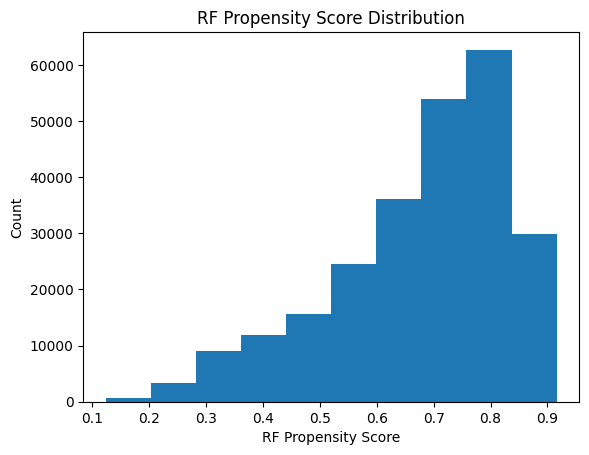

In [5]:
plt.hist(df_matched['e_hat'])
plt.xlabel('RF Propensity Score')
plt.ylabel('Count')
plt.title('RF Propensity Score Distribution')

In [6]:
mod = smf.ols("INCWAGE_LOG ~ CITIZEN", data=df_matched).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:            INCWAGE_LOG   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     126.2
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           2.78e-29
Time:                        00:59:18   Log-Likelihood:            -3.6583e+05
No. Observations:              247790   AIC:                         7.317e+05
Df Residuals:                  247788   BIC:                         7.317e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8153      0.003   3594.831      0.0

In [7]:
tau_hat = 0.0478
se_hat = 0.004
perc = 100 * (np.exp(tau_hat) - 1)
print(perc)

4.896084217541996


In [8]:
perc = 100 * (np.exp(tau_hat) - 1)

ci_low = tau_hat - 1.96 * se_hat
ci_high = tau_hat + 1.96 * se_hat
perc_low = 100 * (np.exp(ci_low) - 1)
perc_high = 100 * (np.exp(ci_high) - 1)

print(f"AIPW effect ≈ {perc:.1f}% change in wages")
print(f"95% CI: [{perc_low:.1f}%, {perc_high:.1f}%]")


AIPW effect ≈ 4.9% change in wages
95% CI: [4.1%, 5.7%]


### Covariate Balance

In [9]:
def to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

def smd(x_treated, x_control):
    # Standardized Mean Difference

    m1, m0 = np.mean(x_treated), np.mean(x_control)
    v1, v0 = np.var(x_treated, ddof=1), np.var(x_control, ddof=1)
    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd

def compute_smd_before(df, covariates):
    treated = df[df["CITIZEN"] == 1]
    control = df[df["CITIZEN"] == 0]

    smds = {}
    for cov in covariates:
        x_t = to_numeric(treated[cov]).dropna()
        x_c = to_numeric(control[cov]).dropna()
        smds[cov] = smd(x_t, x_c)


    return pd.Series(smds, name="SMD Before Matching")

def compute_smd_after(matched_df, covariates):
    treated = matched_df[matched_df["CITIZEN"] == 1]
    control = matched_df[matched_df["CITIZEN"] == 0]

    smds = {}
    for cov in covariates:
        x_t = to_numeric(treated[cov]).dropna()
        x_c = to_numeric(control[cov]).dropna()
        smds[cov] = smd(x_t, x_c)


    return pd.Series(smds, name="SMD After Matching")

In [ ]:
### Rosenbaum Test

treated_matched = df_matched[df_matched["CITIZEN"] == 1].set_index("pair_id")
control_matched = df_matched[df_matched["CITIZEN"] == 0].set_index("pair_id")

common_pairs = treated_matched.index.intersection(control_matched.index)
treated_matched = treated_matched.loc[common_pairs]
control_matched = control_matched.loc[common_pairs]


diffs = treated_matched["INCWAGE_LOG"] - control_matched["INCWAGE_LOG"]

diffs = diffs[diffs != 0]

print(f"Number of informative matched pairs: {len(diffs)}")
print(f"Average Wage Difference (Log points): {diffs.mean():.4f}")

In [ ]:
from scipy.stats import norm

def rosenbaum_bounds(diffs, gamma):
    """
    Calculates the upper bound p-value for the Wilcoxon Signed Rank Test
    given a hidden bias factor Gamma.
    """
    n = len(diffs)
    abs_diffs = np.abs(diffs)
    
    ranks = abs_diffs.rank(method="average")
    
   
    obs_test_stat = ranks[diffs > 0].sum()
    

    p_plus = gamma / (1 + gamma)
    
    e_upper = (p_plus * n * (n + 1)) / 2
    
    v_upper = (n * (n + 1) * (2 * n + 1)) / 24 
    
    z = (obs_test_stat - e_upper) / np.sqrt(v_upper)
    
    p_val = 1 - norm.cdf(z)
    
    return p_val

In [10]:
covariates = ["AGE", "YEARS_IN_US", "SEX", "RACE", "MARST", "IND", "OCC", "STATEFIP", "EDUC"]

smd_before = compute_smd_before(df, covariates)
smd_after = compute_smd_after(df_matched, covariates)

balance_table = pd.concat([smd_before, smd_after], axis=1)
balance_table

,SMD Before Matching,SMD After Matching
AGE,0.556796,-0.128931
YEARS_IN_US,1.036044,0.142725
SEX,0.172727,-0.037183
RACE,-0.269710,0.114552
MARST,-0.246769,0.066896
IND,0.274053,-0.010335
OCC,-0.240357,-0.000134
STATEFIP,-0.062963,0.022126
EDUC,0.397983,0.001999


/var/folders/pg/pcnpvv6d4djdmpvclpppb92m0000gn/T/ipykernel_6539/1402539381.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([smd_before[i], smd_after[i]], [cov, cov], color='black', linewidth=1)


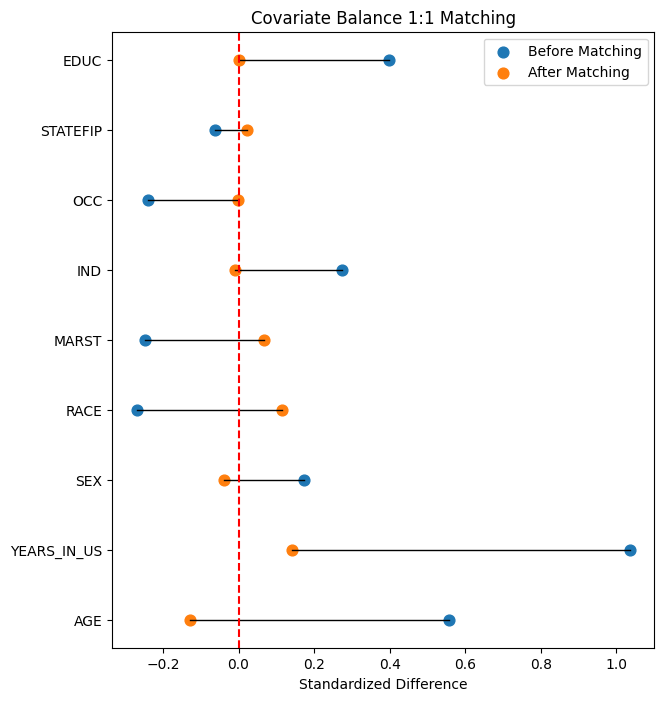

In [11]:
plt.figure(figsize=(7, 8))
plt.scatter(smd_before, covariates, label="Before Matching", s=60)
plt.scatter(smd_after, covariates, label="After Matching", s=60)
for i, cov in enumerate(covariates):
    plt.plot([smd_before[i], smd_after[i]], [cov, cov], color='black', linewidth=1)
plt.axvline(0, color="red", linestyle="--")
plt.title("Covariate Balance 1:1 Matching")
plt.xlabel("Standardized Difference")
plt.legend()
plt.show()

## 1:M Matching

In [12]:
M = 5

In [13]:
treated_ = treated.reset_index(drop=True).copy()
control_ = control.reset_index(drop=True).copy()

nbrsM = NearestNeighbors(n_neighbors=M, algorithm="auto")
nbrsM.fit(control[["e_hat"]])

dist, idx = nbrsM.kneighbors(treated[["e_hat"]])

In [14]:
covars = ["AGE", "YEARS_IN_US", "SEX", "RACE", "MARST",
          "STATEFIP", "EDUC", "OCC", "IND"]
formula0 = "INCWAGE_LOG ~ " + " + ".join(covars)
mu0_model = smf.ols(formula0, data=control).fit()
mu0_treated = mu0_model.predict(treated_[covars]).to_numpy()
mu0_control = mu0_model.predict(control_[covars]).to_numpy()

In [15]:
mu0_i = mu0_treated[:, None]
mu0_k = mu0_control[idx]

assert len(mu0_i) == len(mu0_k)
assert mu0_i.shape[0] == mu0_k.shape[0]

In [16]:
B_i = (mu0_i - mu0_k).mean(axis=1)
bias_hat = B_i.mean()

print("Estimated bias:", bias_hat)

Y_t = treated_["INCWAGE_LOG"].to_numpy()
Y_c = control_["INCWAGE_LOG"].to_numpy()
Y_c_matched = Y_c[idx]
Y_c_bar_i = Y_c_matched.mean(axis=1)
ATT_match = np.mean(Y_t - Y_c_bar_i)

print("Naive matching ATT:", ATT_match)

ATT_bc = ATT_match - bias_hat

print("Bias-corrected ATT:", ATT_bc)

Estimated bias: 0.012629788921126582
Naive matching ATT: 0.058156539595015974
Bias-corrected ATT: 0.04552675067388939


In [17]:
psi_i = (Y_t - Y_c_bar_i) - B_i

n1 = len(psi_i)

var_psi = psi_i.var(ddof=1)

var_ATT_bc = var_psi / n1
se_ATT_bc = np.sqrt(var_ATT_bc)

print("Bias-corrected ATT:", ATT_bc)
print("Standard error:", se_ATT_bc)

Bias-corrected ATT: 0.04552675067388939
Standard error: 0.0026098551091744255


In [18]:
perc = 100 * (np.exp(ATT_bc) - 1)

ci_low = ATT_bc - 1.96 * se_ATT_bc
ci_high = ATT_bc + 1.96 * se_ATT_bc
perc_low = 100 * (np.exp(ci_low) - 1)
perc_high = 100 * (np.exp(ci_high) - 1)

print(f"AIPW effect ≈ {perc:.1f}% change in wages")
print(f"95% CI: [{perc_low:.1f}%, {perc_high:.1f}%]")

AIPW effect ≈ 4.7% change in wages
95% CI: [4.1%, 5.2%]


In [19]:
B = 1000
boot_estimates = np.empty(B)
n1 = len(psi_i)

for b in range(B):
    idx_b = np.random.randint(0, n1, size=n1)
    boot_estimates[b] = psi_i[idx_b].mean()

se_boot = boot_estimates.std(ddof=1)
print("Bootstrap SE (conditional on matches & mu0):", se_boot)

Bootstrap SE (conditional on matches & mu0): 0.0025989162348334007


### Covariate Balance

In [20]:
treated_idx_rep = np.repeat(np.arange(len(treated_)), M)
control_idx_flat = idx.ravel()
matched_treated = treated_.iloc[treated_idx_rep].copy()
matched_control = control_.iloc[control_idx_flat].copy()
matched_df_1M = pd.concat([matched_treated, matched_control], ignore_index=True)

In [24]:
smd_before_1M = compute_smd_before(df, covariates)
smd_after_1M = compute_smd_after(matched_df_1M, covariates)

balance_table_1M = pd.concat([smd_before_1M, smd_after_1M], axis=1)
balance_table_1M

,SMD Before Matching,SMD After Matching
AGE,0.556796,-0.126918
YEARS_IN_US,1.036044,0.142366
SEX,0.172727,-0.041019
RACE,-0.269710,0.110017
MARST,-0.246769,0.066343
IND,0.274053,-0.013970
OCC,-0.240357,-0.009253
STATEFIP,-0.062963,0.011952
EDUC,0.397983,0.002626


/var/folders/pg/pcnpvv6d4djdmpvclpppb92m0000gn/T/ipykernel_6539/2954873858.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([smd_before_1M[i], smd_after_1M[i]], [cov, cov], color='black', linewidth=1)


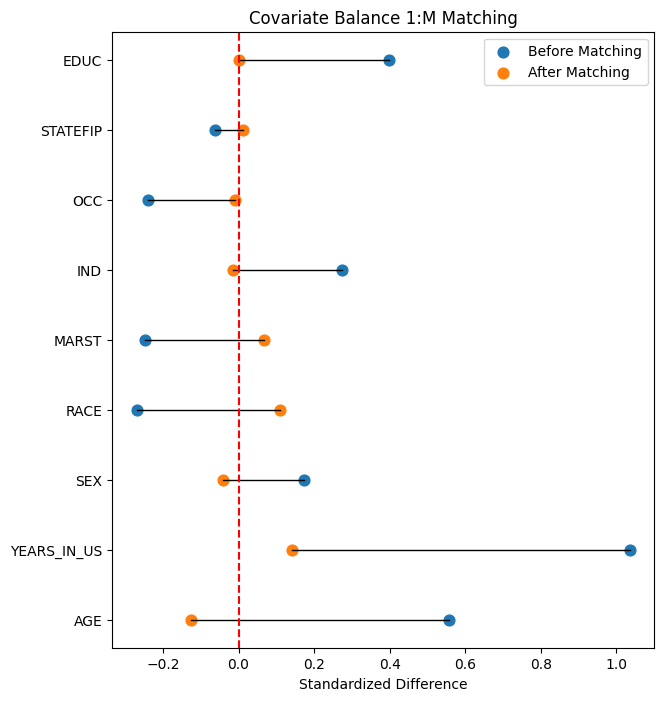

In [25]:
plt.figure(figsize=(7, 8))
plt.scatter(smd_before_1M, covariates, label="Before Matching", s=60)
plt.scatter(smd_after_1M, covariates, label="After Matching", s=60)
for i, cov in enumerate(covariates):
    plt.plot([smd_before_1M[i], smd_after_1M[i]], [cov, cov], color='black', linewidth=1)
plt.axvline(0, color="red", linestyle="--")
plt.title("Covariate Balance 1:M Matching")
plt.xlabel("Standardized Difference")
plt.legend()
plt.show()